<a href="https://colab.research.google.com/github/Minatozaki0911/summerIntern203/blob/master/TTTN203_Tuberculosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
from google.colab import files
print("Please input your kaggle.json API Token")
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
Please input your kaggle.json API Token


In [4]:
ans = input("Do you want to retrain model ? (y/n)\n")
retrain = 0
if ans == 'y':
  retrain = 1
else: 
  retrain = 0
  input('Have you uploaded the model zip file ?\nPlease check the path to your model before continue (OK)\n ')
  !mkdir -p '/content/TB_Model'
  !unzip '/content/TB_Model.zip' -d '/content/TB_Model'
  print('Completed')

Do you want to retrain model ? (y/n)
y


In [2]:
!kaggle datasets download -d raddar/tuberculosis-chest-xrays-shenzhen

100% 3.50G/3.51G [00:59<00:00, 39.0MB/s]
100% 3.51G/3.51G [00:59<00:00, 63.4MB/s]


In [3]:
!unzip '/content/tuberculosis-chest-xrays-shenzhen.zip'

Archive:  /content/tuberculosis-chest-xrays-shenzhen.zip
  inflating: images/images/CHNCXR_0001_0.png  
  inflating: images/images/CHNCXR_0002_0.png  
  inflating: images/images/CHNCXR_0003_0.png  
  inflating: images/images/CHNCXR_0004_0.png  
  inflating: images/images/CHNCXR_0005_0.png  
  inflating: images/images/CHNCXR_0006_0.png  
  inflating: images/images/CHNCXR_0007_0.png  
  inflating: images/images/CHNCXR_0008_0.png  
  inflating: images/images/CHNCXR_0009_0.png  
  inflating: images/images/CHNCXR_0010_0.png  
  inflating: images/images/CHNCXR_0011_0.png  
  inflating: images/images/CHNCXR_0012_0.png  
  inflating: images/images/CHNCXR_0013_0.png  
  inflating: images/images/CHNCXR_0014_0.png  
  inflating: images/images/CHNCXR_0015_0.png  
  inflating: images/images/CHNCXR_0016_0.png  
  inflating: images/images/CHNCXR_0017_0.png  
  inflating: images/images/CHNCXR_0018_0.png  
  inflating: images/images/CHNCXR_0019_0.png  
  inflating: images/images/CHNCXR_0020_0.png  
  i

In [5]:
!head -n 5 shenzhen_metadata.csv

study_id,sex,age,findings
CHNCXR_0001_0.png,Male,45,normal
CHNCXR_0002_0.png,Male,63,normal
CHNCXR_0003_0.png,Female,48,normal
CHNCXR_0004_0.png,Male,58,normal


In [6]:
import os
import cv2
from google.colab.patches import cv2_imshow

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPooling2D, Conv2D
from tensorflow.keras.preprocessing import image
from keras.utils.vis_utils import plot_model
from keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import pandas as pd

In [7]:
df = pd.read_csv('shenzhen_metadata.csv')

df['age'] = np.where(df['age'].between(0, 14), 0, df['age'])
df['age'] = np.where(df['age'].between(15, 27), 1, df['age'])
df['age'] = np.where(df['age'].between(28, 44), 2, df['age'])
df['age'] = np.where(df['age'].between(45, 59), 3, df['age'])
df['age'] = np.where(df['age'].between(60, 180), 4, df['age'])
df['findings'] = np.where(df['findings'].isin(['normal']), df['findings'], 'TB')
df['findings'].value_counts()

TB        336
normal    326
Name: findings, dtype: int64

In [8]:
df['labels'] = df['findings'].map({"normal": 0, "TB": 1})
df['sex_label'] = df['sex'].map({"Male": 0, "Female": 1})
df

,study_id,sex,age,findings,labels,sex_label
0,CHNCXR_0001_0.png,Male,3,normal,0,0
1,CHNCXR_0002_0.png,Male,4,normal,0,0
2,CHNCXR_0003_0.png,Female,3,normal,0,1
3,CHNCXR_0004_0.png,Male,3,normal,0,0
4,CHNCXR_0005_0.png,Male,2,normal,0,0
...,...,...,...,...,...,...
657,CHNCXR_0658_1.png,Male,2,TB,1,0
658,CHNCXR_0659_1.png,Male,2,TB,1,0
659,CHNCXR_0660_1.png,Male,3,TB,1,0
660,CHNCXR_0661_1.png,Male,1,TB,1,0


In [9]:
image_path = '/content/images/images'
model_path = '/content/TB_Model'
w,h = 128, 128

In [10]:
training_df = df[['study_id', 'labels']].copy()
x = training_df['study_id']
y = training_df['labels']

In [11]:
#Creating Dataset from raw data
x_img = []
y_labels = []
for id in range (0, len(x)):
  if id%75==0: 
    print('filename: '+x[id])
    print('label: ', y[id], ', verbose: ', df['findings'][id])
  
  image_path = os.path.join('/content/images/images/', x[id])
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
  clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(8,8))
  hist_equal = cv2.equalizeHist(img)
  if id==420:
    base = img
    equalized = cv2.equalizeHist(base)
    clahed = clahe.apply(base)
  x_img.append(hist_equal)
  y_labels.append(y[id])
print("Number of x_img: ", len(x_img))

filename: CHNCXR_0001_0.png
label:  0 , verbose:  normal
filename: CHNCXR_0076_0.png
label:  0 , verbose:  normal
filename: CHNCXR_0151_0.png
label:  0 , verbose:  normal
filename: CHNCXR_0226_0.png
label:  0 , verbose:  normal
filename: CHNCXR_0301_0.png
label:  0 , verbose:  normal
filename: CHNCXR_0376_1.png
label:  1 , verbose:  TB
filename: CHNCXR_0451_1.png
label:  1 , verbose:  TB
filename: CHNCXR_0526_1.png
label:  1 , verbose:  TB
filename: CHNCXR_0601_1.png
label:  1 , verbose:  TB
Number of x_img:  662


In [12]:
x_img_arr = np.array(x_img)
y_labels_arr = np.array(y_labels)

Difference between image enhancement method


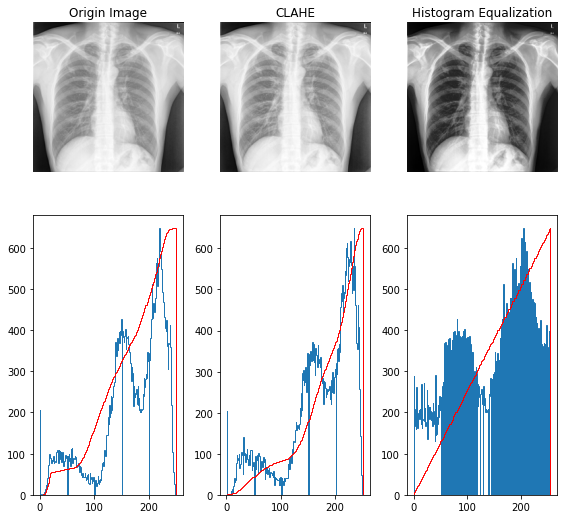

In [13]:
fig, axis = plt.subplots(2, 3, figsize=(8,8))
plt.rc('image', cmap='gray')
#Display image
axis[0][0].imshow(base)
axis[0][0].set_title("Origin Image")
axis[0][0].set_axis_off()
axis[0][1].imshow(clahed)
axis[0][1].set_title("CLAHE")
axis[0][1].set_axis_off()
axis[0][2].imshow(equalized)
axis[0][2].set_title("Histogram Equalization")
axis[0][2].set_axis_off()
#Display Histogram
axis[1][0].hist(base.ravel(), bins=256, histtype='step')
cdf1 = axis[1][0].twinx()
cdf1.set_axis_off()
cdf1.hist(img.ravel(), bins=256, histtype='step', cumulative=True, color='r')
axis[1][1].hist(clahed.ravel(), bins=256, histtype='step')
cdf2 = axis[1][1].twinx()
cdf2.set_axis_off()
cdf2.hist(clahed.ravel(), bins=256, histtype='step', cumulative=True, color='r')
axis[1][2].hist(equalized.ravel(), bins=256, histtype='step')
cdf3 = axis[1][2].twinx()
cdf3.hist(equalized.ravel(), bins=256, histtype='step', cumulative=True, color='r')
cdf3.set_axis_off()
fig.tight_layout()
print("Difference between image enhancement method")

In [14]:
import random
from time import time
random.seed(time())
seed = random.randint(1,200)
x_train, x_test, y_train, y_test = train_test_split(x_img_arr, y_labels_arr,
                                                    test_size=0.2,
                                                    random_state=seed,
                                                    stratify=y_labels_arr)
print("Total images in Validation: " + str(len(x_test)))
print("Total images used for Training: " + str(len(x_train)))

Total images in Validation: 133
Total images used for Training: 529


0 is Normal
1 is Tuberculosis


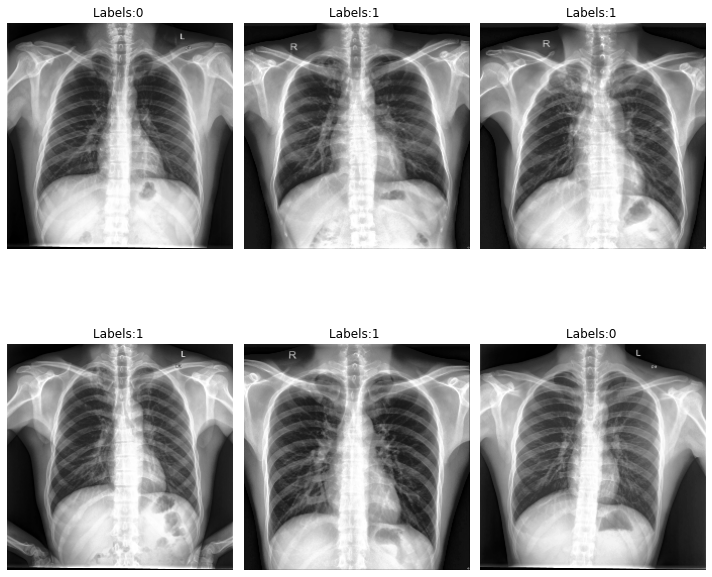

In [15]:
plt.figure(figsize=(10, 10))
offset = seed
print('0 is Normal\n1 is Tuberculosis')
for i in range(6):
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow(x_train[i+offset].astype("uint8"), cmap=plt.cm.gray)
  plt.title("Labels:{} ".format(y_train[i+offset]))
  plt.axis("off")
plt.tight_layout()

In [16]:
#Expand Dimension to 4D tensor
x_train = np.expand_dims(x_train, axis = -1)
y_train = np.expand_dims(y_train, axis = -1)
x_test = np.expand_dims(x_test, axis = -1)
y_test = np.expand_dims(y_test, axis = -1)
print("Training data format: ", x_train.shape)
print("Validation data format: ", x_test.shape)

Training data format:  (529, 224, 224, 1)
Validation data format:  (133, 224, 224, 1)


In [71]:
#CTRL F10 FROM HERE TO RETRAIN EVERYTHING
#ONLY UNCOMMENT BELOW LINE FOR RETRAINING PURPOSE, AFTER THAT RE-COMMENT THIS LINE IMMEDIATELY
#keras.backend.clear_session()

In [72]:
model_path1 = '/content/Model_checkpoint/'
model_checkpoint = ModelCheckpoint(filepath=model_path1, save_best_only=True)
#Reduce overfitting by monitoring on validation accuracy metric
early_stopping = EarlyStopping(monitor='val_acc',
                               min_delta=0,
                               patience=7,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True)

In [73]:
def image_model():
  input_shape = Input(shape=(224,224,1))
  #Paralel Feature extraction
  #Standard route
  block1 = Conv2D(16, (3,3), padding='same', activation='relu')(input_shape)
  block1 = Conv2D(16, (3,3), padding='same', activation='relu')(block1)
  block1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(block1)
  block1 = Conv2D(32, (3,3), padding='same', activation='relu')(block1)
  block1 = Conv2D(32, (3,3), padding='same', activation='relu')(block1)
  block1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(block1)
  #Detailed route
  block2 = Conv2D(32, (3,3), padding='same', activation='relu')(input_shape)
  block2 = Conv2D(64, (3,3), padding='same', activation='relu')(block2)
  block2 = MaxPooling2D(pool_size=4, padding='same', strides=2)(block2)
  block2 = Conv2D(64, (3,3), padding='same', activation='relu')(block2)
  block2 = Conv2D(32, (3,3), padding='same', activation='relu')(block2)
  block2 = MaxPooling2D(pool_size=4, padding='same', strides=2)(block2)
  #Generalize route
  block3 = Conv2D(16, (7,7), padding='same', activation='relu')(input_shape)
  block3 = Conv2D(16, (7,7), padding='same', activation='relu')(block3)
  block3 = MaxPooling2D(pool_size=(5,5), padding='same', strides=(2,2))(block3)
  block3 = Conv2D(32, (7,7), padding='same', activation='relu')(block3)
  block3 = Conv2D(32, (7,7), padding='same', activation='relu')(block3)
  block3 = MaxPooling2D(pool_size=(5,5), padding='same', strides=(2,2))(block3)

  #Fully connected layer
  merged = keras.layers.concatenate([block1, block2, block3], axis=1)
  merged = Flatten()(merged)

  hidden1 = Dense(256, activation='relu')(merged)
  hidden1 = Dropout(0.3)(hidden1)
  hidden1 = Dense(128, activation='relu')(merged)
  hidden1 = Dropout(0.2)(hidden1)
  hidden1 = Dense(64, activation='relu')(merged)
  hidden1 = Dropout(0.1)(hidden1)
  hidden1 = Dense(32, activation='relu')(merged)
  hidden1 = Dropout(0.05)(hidden1)
  predict = Dense(1, activation='sigmoid', name='Predict')(hidden1)
  
  model = Model(input_shape, predict)
  return model

In [74]:
#Momentum Learning rate
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.9, staircase=True)

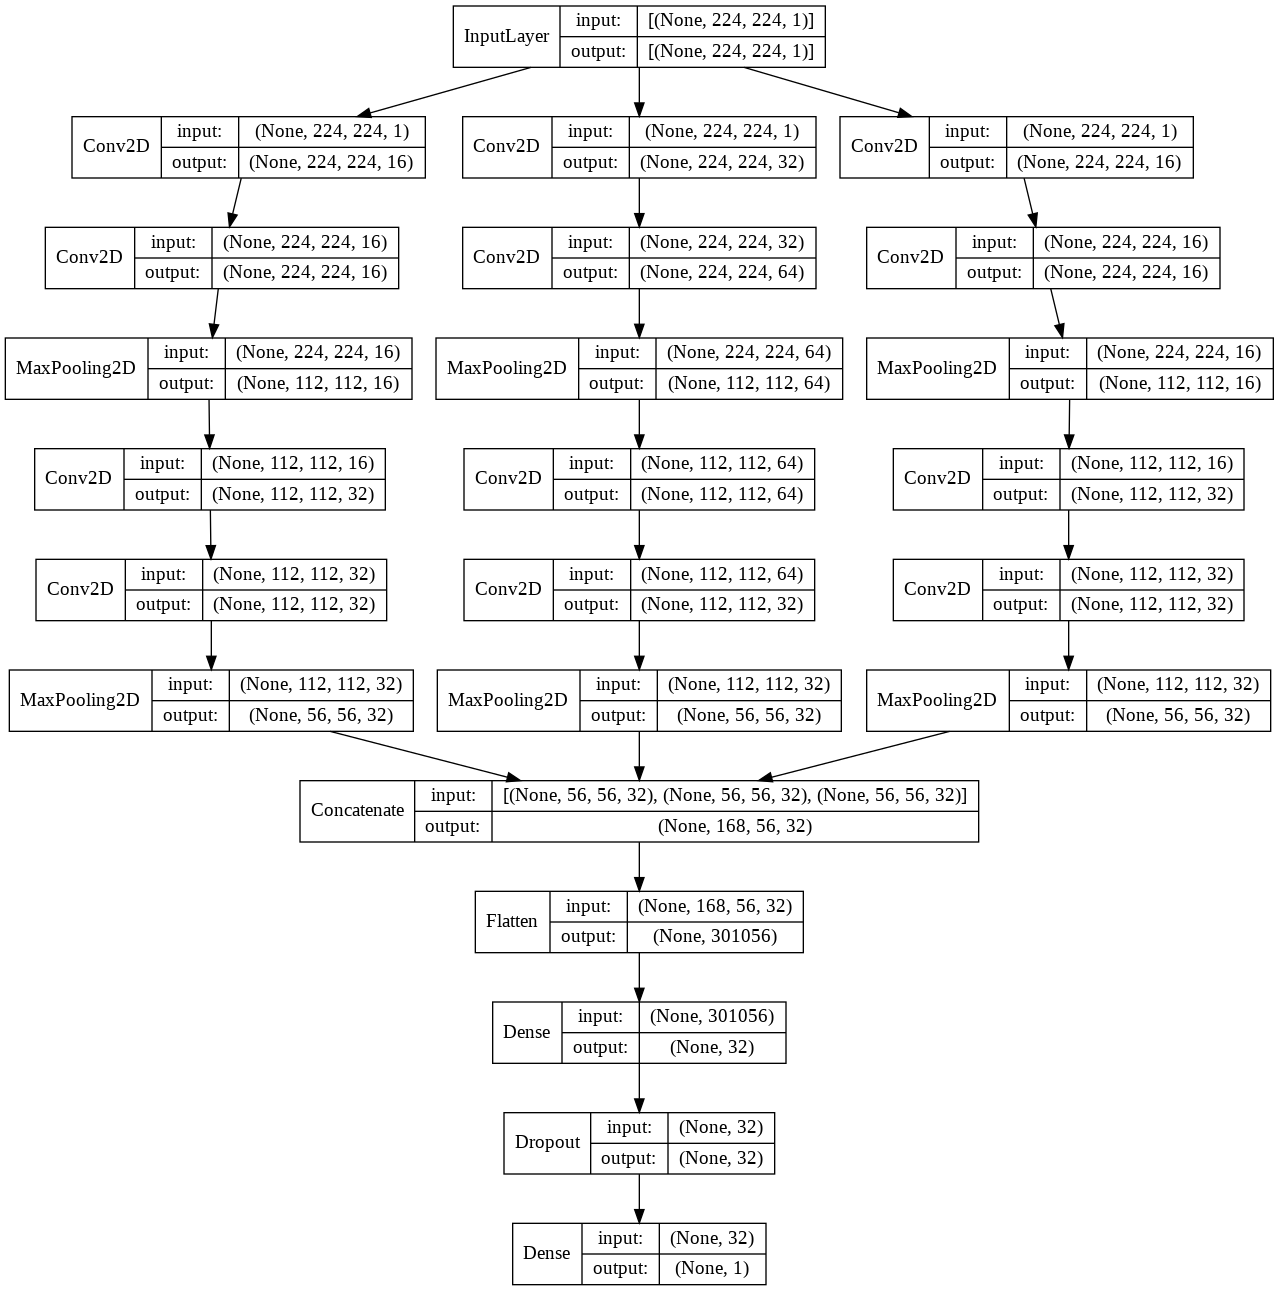

In [75]:
model = image_model()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [76]:
model.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics=['acc'])


In [77]:
if retrain:
  history = model.fit(x_train, y_train, 
                      epochs=50, 
                      batch_size=32, 
                      validation_data=(x_test, y_test),
                      verbose=1,
                      callbacks=[early_stopping, model_checkpoint])
else: 
  #Wait for unzipping progress complete. This can be very long since the model is about 110MBs
  while (not os.path.exists(os.path.join('/content/TB_Model', 'saved_model.pb'))):
    pass
  model = load_model(model_path, compile=True)

Epoch 1/50
17/17 [==============================] - 11s 551ms/step - loss: 26.6874 - acc: 0.5274 - val_loss: 0.6614 - val_acc: 0.6241
INFO:tensorflow:Assets written to: /content/Model_checkpoint/assets
Epoch 2/50
17/17 [==============================] - 9s 533ms/step - loss: 0.7560 - acc: 0.6389 - val_loss: 0.5890 - val_acc: 0.6992
INFO:tensorflow:Assets written to: /content/Model_checkpoint/assets
Epoch 3/50
17/17 [==============================] - 9s 532ms/step - loss: 0.4914 - acc: 0.7864 - val_loss: 0.6059 - val_acc: 0.7970
Epoch 4/50
17/17 [==============================] - 9s 530ms/step - loss: 0.5020 - acc: 0.8053 - val_loss: 0.5365 - val_acc: 0.7594
INFO:tensorflow:Assets written to: /content/Model_checkpoint/assets
Epoch 5/50
17/17 [==============================] - 9s 531ms/step - loss: 0.4089 - acc: 0.8261 - val_loss: 0.5526 - val_acc: 0.7895
Epoch 6/50
17/17 [==============================] - 9s 533ms/step - loss: 0.4087 - acc: 0.8223 - val_loss: 0.4992 - val_acc: 0.7970
IN

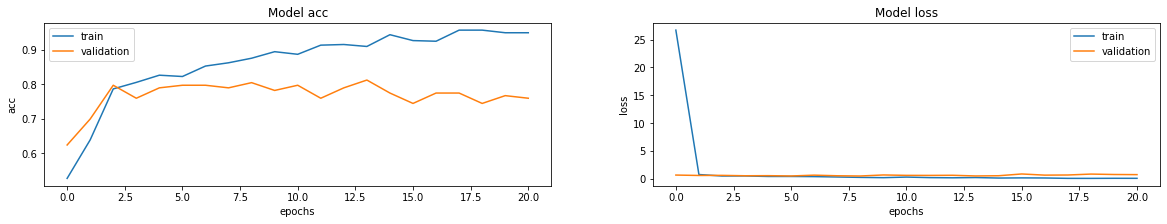

In [78]:
if retrain:
  fig, ax = plt.subplots(1, 2, figsize=(20, 3))
  ax = ax.ravel()
  for i, metric in enumerate(['acc', 'loss']):
      ax[i].plot(model.history.history[metric])
      ax[i].plot(model.history.history["val_" + metric])
      ax[i].set_title("Model {}".format(metric))
      ax[i].set_xlabel("epochs")
      ax[i].set_ylabel(metric)
      ax[i].legend(["train", "validation"])

In [79]:
prediction = model.predict(x_test)

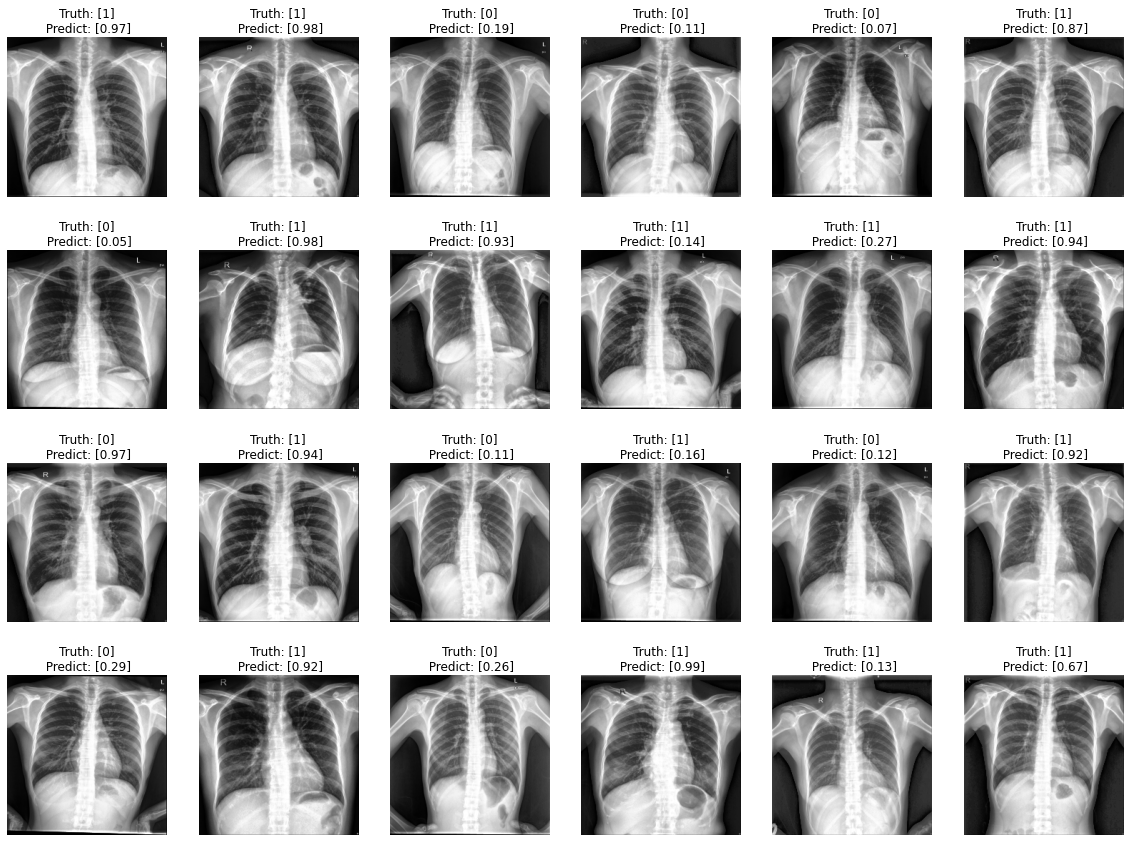

In [80]:
plt.figure(figsize=(20, 15))
for i in range(24):
  ax = plt.subplot(4, 6, i + 1)
  plt.imshow(np.squeeze(x_test[i]).astype("uint8"), cmap=plt.cm.gray)
  plt.title("Truth: {}\n Predict: {}".format(y_test[i], prediction[i].round(2)))
  plt.axis("off")

In [81]:
count = 0
validation_sample = len(y_test)
print("Total validation sample: ", validation_sample)
for i in range(validation_sample):
  if prediction.round(0).astype(np.int)[i]== y_test[i]:
    count += 1
print("Correct prediction:      " ,count)


Total validation sample:  133
Correct prediction:       108


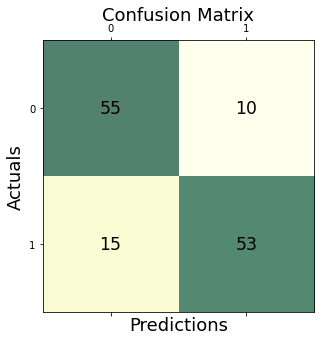

In [82]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=prediction.round(0).astype(np.int))
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(conf_matrix, cmap=plt.cm.YlGn, alpha=0.68)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [83]:
print(classification_report(y_true=y_test, y_pred=prediction.round(0).astype(np.int)))

              precision    recall  f1-score   support

           0       0.79      0.85      0.81        65
           1       0.84      0.78      0.81        68

    accuracy                           0.81       133
   macro avg       0.81      0.81      0.81       133
weighted avg       0.81      0.81      0.81       133



In [84]:
#Prediction for entire dataset
y_labels_pred = model.predict(x_img_arr)

In [85]:
y_labels_pred = y_labels_pred.round(0).astype(np.int)
count = 0
population = len(y_labels_pred)
print("Dataset population: ", population)
for i in range(population):
  if y_labels_pred[i] == y_labels_arr[i]:
    count += 1
print("Correct percentage: {:.2f}".format((count/population)*100))


Dataset population:  662
Correct percentage: 93.20


In [86]:
#Make new dataFrame with y_labels_pred
df['prediction'] = y_labels_pred.squeeze(axis=-1)
train_df = df[['age', 'sex_label', 'prediction', 'labels']].copy()
print(train_df)
label_df = train_df.pop('labels')
train_df = np.array(train_df)
label_df = np.array(label_df)
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(train_df, label_df,
                                                    test_size=0.2,
                                                    random_state=seed,
                                                    stratify=label_df)
x_train_df

     age  sex_label  prediction  labels
0      3          0           0       0
1      4          0           0       0
2      3          1           0       0
3      3          0           0       0
4      2          0           0       0
..   ...        ...         ...     ...
657    2          0           1       1
658    2          0           1       1
659    3          0           1       1
660    1          0           1       1
661    2          0           1       1

[662 rows x 4 columns]


array([[1, 0, 0],
       [2, 0, 1],
       [2, 0, 1],
       ...,
       [2, 0, 1],
       [1, 1, 1],
       [1, 0, 0]])

In [87]:
def ANN():
  model = Sequential()
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))
  return model

In [88]:
#!mkdir -p '/content/final_model_checkpoint'
#model2_path = '/content/final_model_checkpoint'
#model2_checkpoint = ModelCheckpoint(filepath=model_path, save_best_only=True)
#early_stopping = EarlyStopping(monitor='val_loss',
#                               min_delta=0,
#                               patience=10,
#                               verbose=1,
#                               mode='auto',
#                              restore_best_weights=True)


In [89]:
model2 = ANN()
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                 loss='binary_crossentropy',
                 metrics=['acc'])
history = model2.fit(x_train_df, y_train_df, 
                epochs=70, 
                batch_size=32,
                validation_data=(x_test_df, y_test_df),
                callbacks=[early_stopping, model2_checkpoint])

Epoch 1/70
17/17 [==============================] - 1s 16ms/step - loss: 0.6738 - acc: 0.6238 - val_loss: 0.6759 - val_acc: 0.5188
Epoch 2/70
17/17 [==============================] - 0s 6ms/step - loss: 0.6648 - acc: 0.6446 - val_loss: 0.6630 - val_acc: 0.5188
Epoch 3/70
17/17 [==============================] - 0s 6ms/step - loss: 0.6412 - acc: 0.7391 - val_loss: 0.6459 - val_acc: 0.7293
Epoch 4/70
17/17 [==============================] - 0s 6ms/step - loss: 0.6225 - acc: 0.7996 - val_loss: 0.6273 - val_acc: 0.8120
Epoch 5/70
17/17 [==============================] - 0s 6ms/step - loss: 0.5968 - acc: 0.8526 - val_loss: 0.6081 - val_acc: 0.8120
Epoch 6/70
17/17 [==============================] - 0s 6ms/step - loss: 0.5721 - acc: 0.8828 - val_loss: 0.5885 - val_acc: 0.8120
Epoch 7/70
17/17 [==============================] - 0s 6ms/step - loss: 0.5480 - acc: 0.8960 - val_loss: 0.5681 - val_acc: 0.8120
Epoch 8/70
17/17 [==============================] - 0s 6ms/step - loss: 0.5221 - acc: 0.8

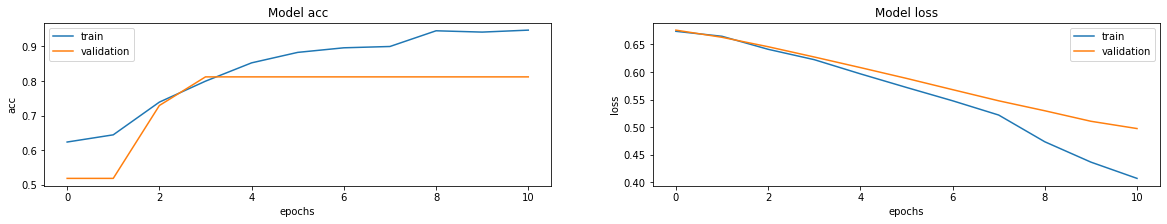

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()
for i, metric in enumerate(['acc', 'loss']):
    ax[i].plot(model2.history.history[metric])
    ax[i].plot(model2.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "validation"])

In [91]:
prediction2 = model2.predict(x_test_df)

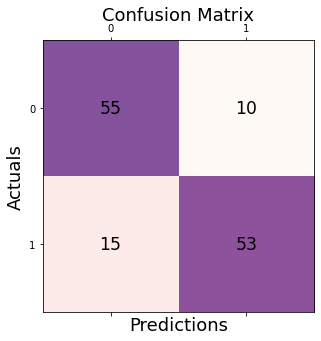

In [92]:
conf_matrix = confusion_matrix(y_true=y_test_df, y_pred=prediction2.round(0).astype(np.int))
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(conf_matrix, cmap=plt.cm.RdPu, alpha=0.68)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [93]:
print(classification_report(y_true=y_test_df, y_pred=prediction2.round(0).astype(np.int)))

              precision    recall  f1-score   support

           0       0.79      0.85      0.81        65
           1       0.84      0.78      0.81        68

    accuracy                           0.81       133
   macro avg       0.81      0.81      0.81       133
weighted avg       0.81      0.81      0.81       133

